In [9]:
import os, datetime
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (16, 5)
mpl.rcParams['axes.grid'] = False

#dfn.plot(subplots=True)
#trainPercent = .7
tf.random.set_seed(13)

def get_data(dataset, target, start_index, end_index, history,
                      target_size, step=1, single_step=False):
    data = []
    labels = []

    start_index = start_index + history
    if end_index is None:
        end_index = len(dataset) - target_size

    hist = int(history/step);
    for i in range(start_index, end_index):
        #print(f"++ {i}  {start_index} {end_index} \r", end="")
        indices = range(i-history, i, step)
        
        dt = np.reshape(dataset[indices], ( hist, -1))
        data.append(dt)

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

# target: column to predict
# history      : how long of history to look
# target_ahead : how much in the future "target" is predicted
#      =>confusing!! if values right next to it is predicted, it is =0
#      if say, you lke to predict 5 time steps aheads then it is 5
#
# skip:         sample size - items to skip  (down sample)
# single_step : # predictions
# pct         : percentage split or a number of samples
def get_split(df, history,target=None, pct=0.7, 
                  target_ahead=0, skip=1, single_step=True):

    TRAIN_SPLIT = int(len(df) * trainPercent) if (pct < 1) else pct
    target = target if target else df.columns[0]
    
    print(f"Training_split: {TRAIN_SPLIT}, target: {target}")
    
    scaler = StandardScaler()
    dfs = scaler.fit(df[:TRAIN_SPLIT])
    dfs.mean_, dfs.scale_
    dfns = (df-dfs.mean_)/dfs.scale_ 
    
    ds = dfns.values
    xtrn, ytrn = get_data(ds, dfns[target].values, 0, TRAIN_SPLIT,
                        history, target_ahead, skip,True)
    xval, yval = get_data(ds, dfns[target].values, TRAIN_SPLIT, None,
                        history, target_ahead, skip,True)
    
    return scaler, dfns, xtrn, ytrn, xval, yval



In [ ]:
#get_split(dfn2, 720,0, 300000,72,6,True)

In [97]:
class TimeSeriesLSTM:
    '''
    df    : data frame
    UNITS1: # units in layer1 of LSTM
    UNITS2: # units in layer2 of LSTM, 0 if one layer
    nfeats: number of features
    '''
    def __init__(self, history, nfeats, 
                 target_ahead = 0, skip=1,
                 UNITS1=32, UNITS2=0, npreds=1, verbose=1,
                 OPTIMIZER = 'adam', model_file="temp.hd5"
                ):
        self.UNITS1       = UNITS1 or 32
        self.UNITS2       = UNITS2 or 0
        self.history      = history
        self.NPREDS       = npreds
        self.target_ahead = target_ahead
        
        self.nfeats       = nfeats
        self.skip         = skip
        self.BATCH_SIZE   = 256
        self.BUFFER_SIZE  = 10000
        self.EPOCHS       = 20
        self.LOSS         = "mae"
        self.OPTIMIZER    = tf.keras.optimizers.RMSprop(clipvalue=1.0)
        self.OPTIMIZER    = OPTIMIZER
        self.EVAL_INTERVAL= 200
        self.VAL_STEPS    = 50
        self.V            = verbose
        self.model_file   = model_file

    def model(self):
        m = tf.keras.models.Sequential()
        dim1 = int(self.history/self.skip)
        
        m.add(LSTM(self.UNITS1, return_sequences= (self.NPREDS >1),
                        input_shape=(dim1, self.nfeats) ))
        if(self.UNITS2):
            m.add(tf.keras.layers.LSTM(self.UNITS2, activation='relu'))
        m.add(tf.keras.layers.Dense(self.NPREDS))
        m.compile(optimizer = self.OPTIMIZER, loss=self.LOSS)
        
        self.model = m
        return m
    
    def prepare(self, dfn,target=None, pct=0.7):
        self.DFN    = dfn;
        self.target = target
        skip        = self.skip
        
        ret = get_split( dfn, self.history, target, pct,
                        self.target_ahead, skip,
                        single_step = (self.NPREDS <= 1) )

        scaler, df, xtrn, ytrn, xval, yval = ret
        
        trn = tf.data.Dataset.from_tensor_slices((xtrn, ytrn))
        trn = trn.cache().shuffle(self.BUFFER_SIZE).batch(
                self.BATCH_SIZE).repeat()

        val = tf.data.Dataset.from_tensor_slices((xval, yval))
        val = val.batch(self.BATCH_SIZE).repeat()

        self.scaler, self.df, self.xtrn, self.ytrn,  \
                                self.xval, self.yval = ret
        self.trn, self.val = trn, val
        
        return self.DFN, self.target, skip, ret, trn, val
 
    def prepSet(self,prepped):
        self.DFN, self.target, self.skip, ret, self.trn, self.val = prepped
        self.scaler, self.df, self.xtrn, self.ytrn,  \
                                self.xval, self.yval = ret
    
    class CB(tf.keras.callbacks.Callback):
        def on_train_batch_begin(self, batch, logs=None):
            pass
            #print(f'Training: batch +{batch}');

        def on_train_batch_end(self, batch, logs=None):
            pass;
            #print(f'Training: batch -{batch}')

        def on_test_batch_begin(self, batch, logs=None):
            print(f'Eval: batch +{batch} \r', end='')

        def on_test_batch_end(self, batch, logs=None):
            print(f'Eval: batch -{batch} \r', end='')

    def fit(self, epochs=None, verbose=None):
        
        epochs = epochs  or self.EPOCHS
        verbose= verbose or self.V
        
        trn, val = self.trn, self.val
        self.model.fit(trn, verbose=verbose, epochs=epochs,
                steps_per_epoch = self.EVAL_INTERVAL,
                validation_data = val, validation_steps=self.VAL_STEPS,
                      callbacks=[self.CB()])
        
    def predictPlot(self,start=0, howmany=100):
        history      = self.history
        npreds       = self.NPREDS
        skip         = self.skip
        single_step  = (self.NPREDS <= 1) 
        target_ahead = self.target_ahead
        dfn1         = self.DFN; 
        lstm         = self.model
        scaler       = self.scaler
        target       = self.target
        
        TimeSeriesLSTM.predictPlot_( start    , howmany, history,
                                     npreds   , skip   , single_step  ,
                                     dfn1     , lstm   ,  target_ahead ,
                                     scaler   , target 
                   )
        
    def predictPlot_(start    , howmany, history      ,
                     npreds   , skip   , single_step  ,
                     dfn1     , lstm   ,  target_ahead ,
                     scaler   , target 
                   ):        
        ds1   = dfn1[start:start+howmany+history+1].values

        xp, yp = get_data(ds1, ds1[:, target], 0, None,
                             history, npreds, skip, single_step)
        
        for i,x  in enumerate(xp):
            xp[i] = scaler.transform(xp[i])

        yh1= lstm.predict(xp)
        
        #yh = scaler.inverse_transform(yh1)
        yh = yh1 * scaler.scale_[target]
        yh = yh  + scaler.mean_[target]

        #print(xtrn[0], ytrn[0],dfn.iloc[0])
        target = dfn.columns[0]

        idx= dfn.index  [history+target_ahead : history+howmany]
        act= dfn[target][history+target_ahead : history+howmany] 

        plt.plot(idx,yp, marker=".")
        plt.plot(idx,yh, marker="x", color="r")
        plt.xticks(rotation=45);
        plt.grid(b="on")
        #pr = lstm.predict(xtrn[1].reshape(1,xtrn[0

    def save(self):
        self.model.save(self.model_file)

    def load(self):
        self.model = load_model(self.model_file)
        

In [5]:
load = 0
if (load):
    csv_path = 'jena_climate_2009_2016.csv.zip'
    df = pd.read_csv(csv_path)
    df['Date Time'] = pd.to_datetime( df['Date Time'] )

    dfn1= df[['T (degC)']].copy()
    dfn1.index = df['Date Time']

    dfn2= df[['T (degC)', 'p (mbar)', 'rho (g/m**3)']].copy()
    dfn2.index = df['Date Time']

    dfn = dfn2
    dfn

In [6]:
lmodel = TimeSeriesLSTM(history=20, nfeats=1, target_ahead=0, skip=1,
                 UNITS1=32, UNITS2=0, npreds=1, verbose=0)

lmodel.model()
preload=0
if (preload):
    lmodel.load()
    lmodel.prepSet(prep)
else:
    prep=lmodel.prepare(dfn1,0, 300000)
    lmodel.save()
    
lmodel.fit()


Training_split: 300000, target: T (degC)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: temp.hd5/assets


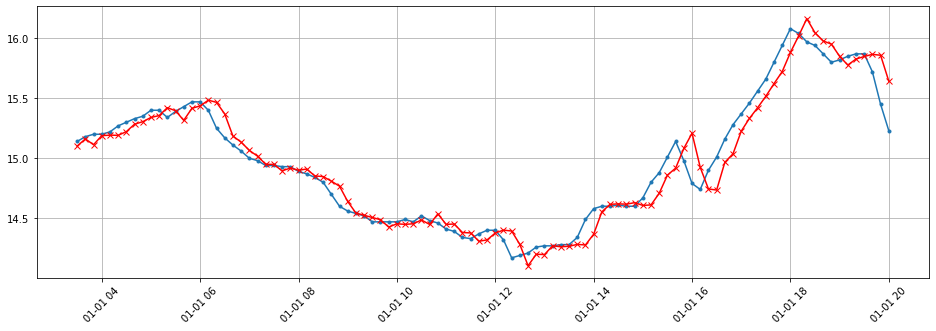

In [10]:
lmodel.predictPlot(300100,100)

In [43]:
preload=0

lmodel1 = TimeSeriesLSTM(history=720, nfeats=3, target_ahead=72, skip=6,
                 UNITS1=32, UNITS2=0, npreds=1, verbose=0)
lmodel1.model()

if (preload == 1):
    lmodel1.load()
    lmodel1.prepSet(prep)
elif(preload == 0):
    prep=lmodel1.prepare(dfn2,0,300000)
    lmodel1.save()
    
lmodel1.fit()


Training_split: 300000, target: T (degC)
INFO:tensorflow:Assets written to: temp.hd5/assets


In [95]:
lmodel1.fit()


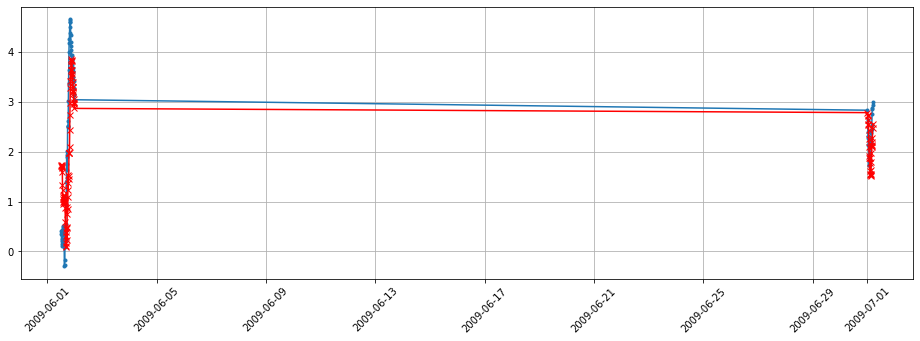

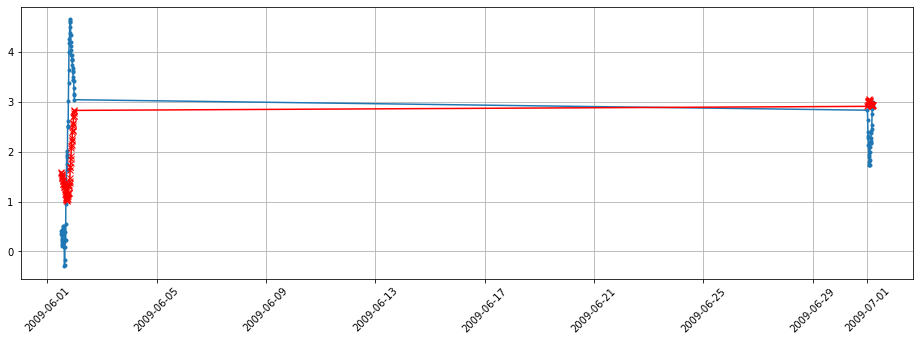

In [99]:
def predictPlot_(start    , howmany, history      ,
                 npreds   , skip   , single_step  ,
                 dfn1     , lstm   ,  target_ahead ,
                 scaler   , target 
               ):        
    ds1   = dfn1[start:start+howmany+history+1].values

    xp, yp = get_data(ds1, ds1[:, target], 0, None,
                         history, npreds, skip, single_step)

    for i,x  in enumerate(xp):
        xp[i] = scaler.transform(xp[i])

    yh1= lstm.predict(xp)

    #yh = scaler.inverse_transform(yh1)
    yh = yh1 * scaler.scale_[target]
    yh = yh  + scaler.mean_[target]

    #print(xtrn[0], ytrn[0],dfn.iloc[0])
    target = dfn.columns[0]

    st = history+target_ahead
    idx= dfn.index  [st : st+howmany]

    plt.plot(idx,yp, marker=".")
    plt.plot(idx,yh, marker="x", color="r")
    plt.xticks(rotation=45);
    plt.grid(b="on")
    #pr = lstm.predict(xtrn[1].reshape(1,xtrn[0

#lmodel1.predictPlot(300100,100)
predictPlot_(310000,100, 720,1,6,1,dfn2,lmodel1.model,72,lmodel1.scaler,0)
plt.show()
predictPlot_(310000,100, 720,1,6,1,dfn2,single_step_model,72,lmodel1.scaler,0)


In [54]:
yp.shape,idx.shape

((100,), (100,))

# ORIGINAL Code before modification

=======

Date Time
2009-01-01 00:10:00   -8.02
2009-01-01 00:20:00   -8.41
2009-01-01 00:30:00   -8.51
2009-01-01 00:40:00   -8.31
2009-01-01 00:50:00   -8.27
                       ... 
2016-12-31 23:20:00   -4.05
2016-12-31 23:30:00   -3.35
2016-12-31 23:40:00   -3.16
2016-12-31 23:50:00   -4.23
2017-01-01 00:00:00   -4.82
Name: T (degC), Length: 420551, dtype: float64

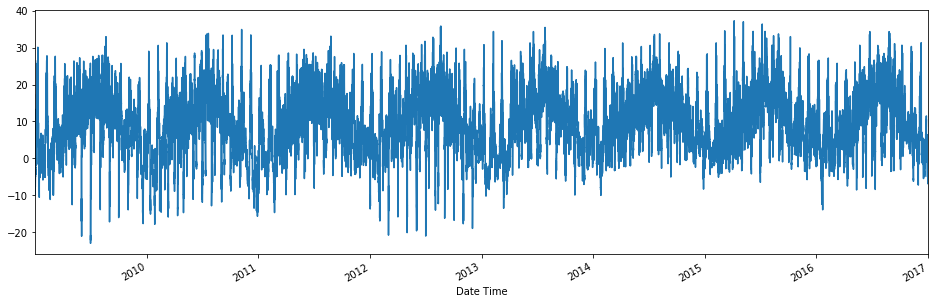

In [63]:
#In both the following tutorials, the first 300,000 rows of the data will be the training dataset, and 
#there remaining will be the validation dataset. This amounts to ~2100 days worth of training data.

TRAIN_SPLIT = 300000
tf.random.set_seed(13)      #Setting seed to ensure reproducibility.

# Univariant - single step prediction
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.plot(subplots=True)
uni_data

In [64]:
#It is important to scale features before training a neural network. Standardization is a 
#common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.
#You could also use a `tf.keras.utils.normalize` method that rescales the values into a range of [0,1].

#***NOTE*** Note: The mean and standard deviation should only be computed using the training data.
#
uni_data = uni_data.values

uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std
uni_data

array([-1.99766294, -2.04281897, -2.05439744, ..., -1.43494935,
       -1.55883897, -1.62715193])

In [65]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    #print(f"++ {i}  {start_index} {end_index} \r", end="")
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    dt = np.reshape(dataset[indices], (history_size, -1))
    data.append(dt)
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

#Let's now create the data for the univariate model. For part 1, the model will be given the 
#last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT, univariate_past_history, univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,  univariate_past_history, univariate_future_target)

print ('Single window of past history:', x_train_uni[0])
print ('\n Target temperature to predict', y_train_uni[0])

Single window of past history: [[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict -2.1041848598100876


In [66]:
#This is what the `univariate_data` function returns.
len(x_train_uni)

299980

Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [67]:
def create_time_steps(length):
  return list(range(-length, 0))

<module 'matplotlib.pyplot' from '/Users/e346104/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

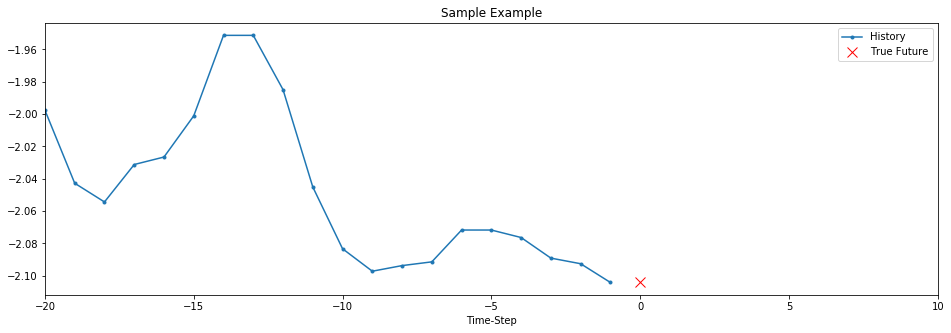

In [68]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [69]:
def baseline(history):
  return np.mean(history)

baseline(x_train_uni)

4.135588689781763e-05

<module 'matplotlib.pyplot' from '/Users/e346104/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

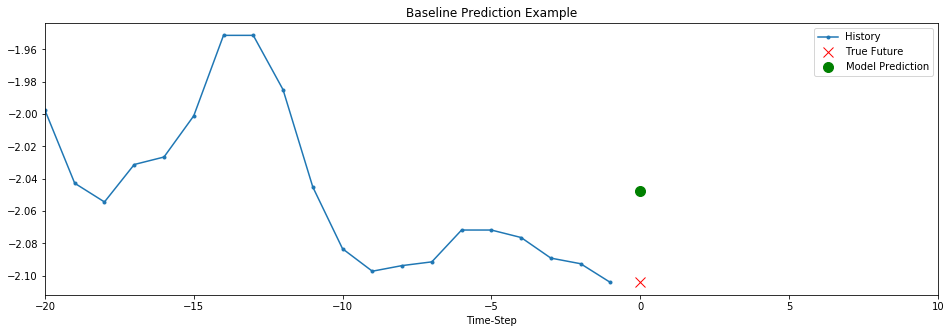

In [70]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [71]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

You will see the LSTM requires the input shape of the data it is being given.

In [72]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to check the output of the model. 

In [73]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [74]:
#x_train_uni.shape, x_val_uni.shape, x_train_uni,x_val_uni

Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [75]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0286 - val_loss: 0.0206
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0263 - val_loss: 0.0197
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0253 - val_loss: 0.0182
Epoch 10/10
200/200 [==============================] - 2

#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

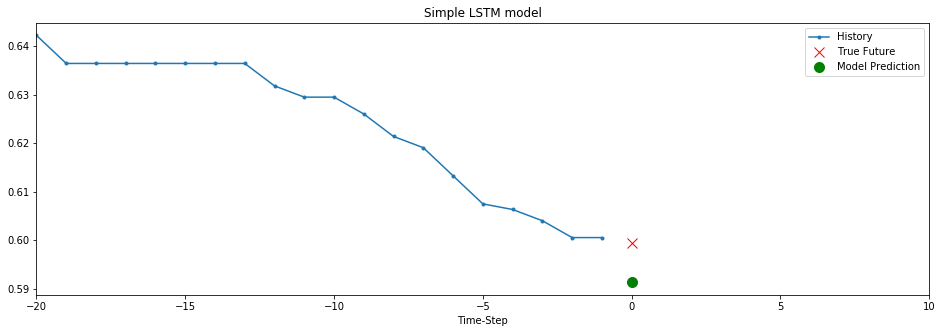

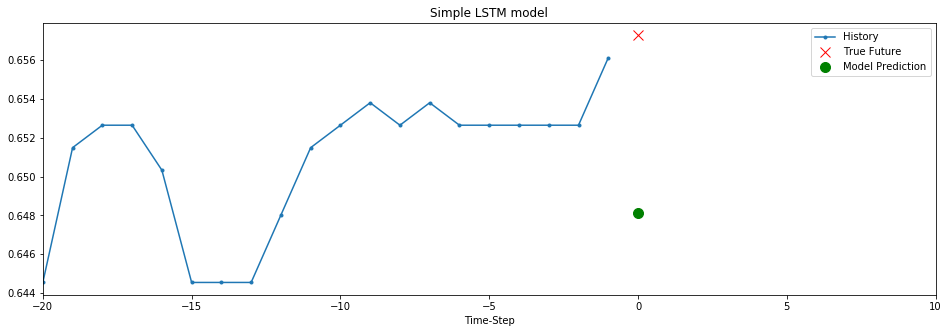

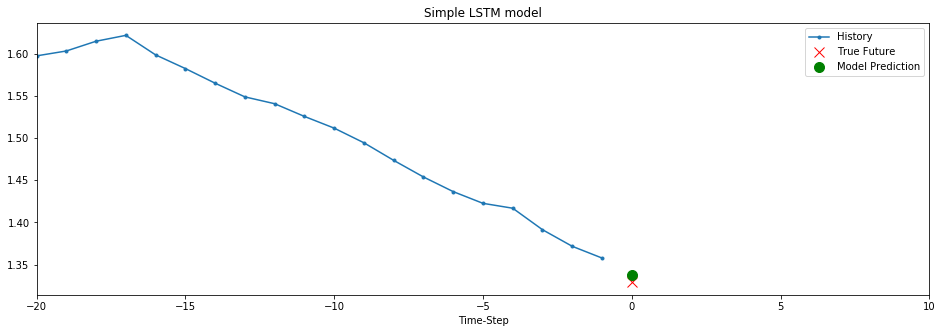

In [76]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

## Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [77]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [78]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
2009-01-01 00:10:00,996.52,-8.02,1307.75
2009-01-01 00:20:00,996.57,-8.41,1309.80
2009-01-01 00:30:00,996.53,-8.51,1310.24
2009-01-01 00:40:00,996.51,-8.31,1309.19
2009-01-01 00:50:00,996.51,-8.27,1309.00


Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc18085dfd0>,
      dtype=object)

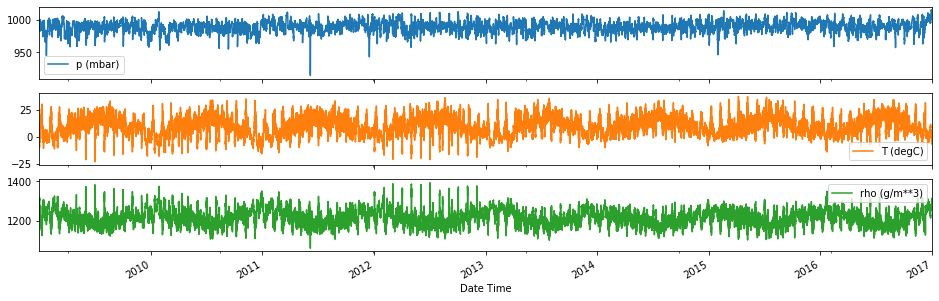

In [79]:
features.plot(subplots=True)

As mentioned, the first step will be to standardize the dataset using the mean and standard deviation of the training data.

In [80]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [81]:
dataset = (dataset-data_mean)/data_std

### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [82]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days.  For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

In [83]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.


In [84]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))
#x_train_single.shape, y_train_single.shape, x_val_single.shape, y_val_single.shape

Single window of past history : (120, 3)


In [85]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [86]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's check out a sample prediction.

In [87]:
x_train_single.shape[-2:]

(120, 3)

In [88]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [89]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 11s 57ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 10s 49ms/step - loss: 0.2624 - val_loss: 0.2435
Epoch 3/10
200/200 [==============================] - 10s 49ms/step - loss: 0.2613 - val_loss: 0.2489
Epoch 4/10
200/200 [==============================] - 10s 50ms/step - loss: 0.2571 - val_loss: 0.2454
Epoch 5/10
200/200 [==============================] - 10s 52ms/step - loss: 0.2264 - val_loss: 0.2376
Epoch 6/10
200/200 [==============================] - 10s 51ms/step - loss: 0.2412 - val_loss: 0.2708
Epoch 7/10
200/200 [==============================] - 10s 49ms/step - loss: 0.2409 - val_loss: 0.2504
Epoch 8/10
200/200 [==============================] - 10s 48ms/step - loss: 0.2402 - val_loss: 0.2387
Epoch 9/10
200/200 [==============================] - 10s 50ms/step - loss: 0.2447 - val_loss: 0.2440
Epoch 10/10
200/200 [==================

In [90]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

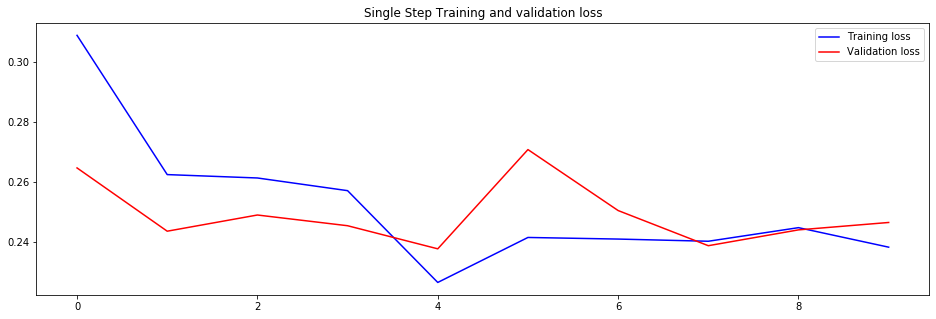

In [91]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

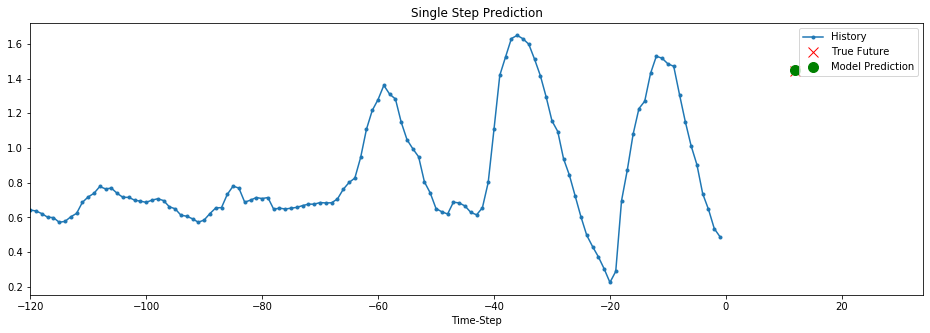

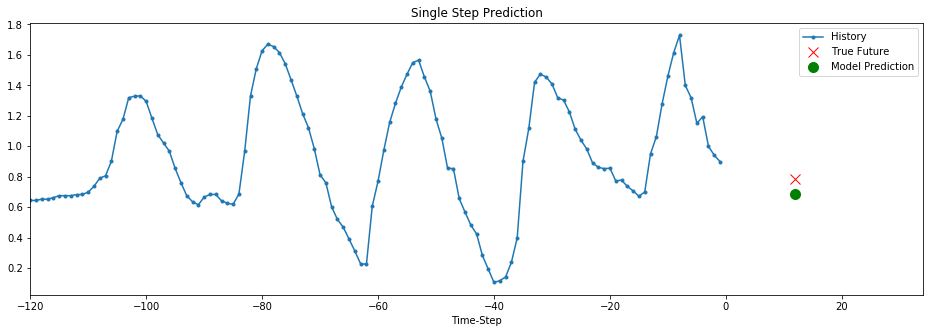

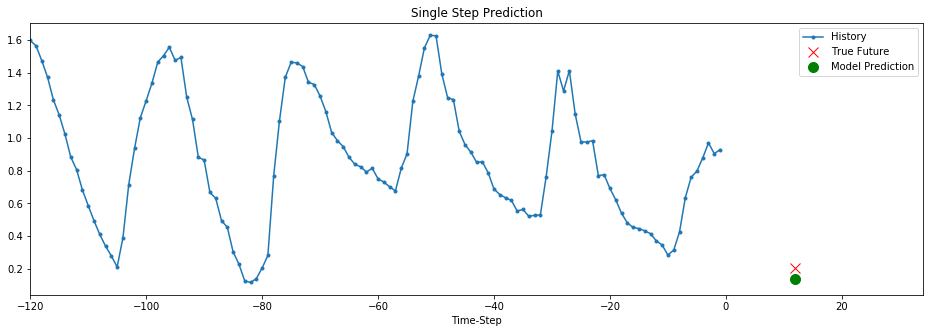

In [92]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [ ]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [ ]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

In [ ]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [ ]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])